In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import os

### Import dataset and put into dataloader

In [2]:
# import CIFAR-10 dataset into trainset, testset
# load in to trainloader, testloader

# color dataset
transform_color = transforms.Compose([
        transforms.ToTensor(),
         transforms.Normalize((0.5), (0.5))
    ])

batchSize = 16

trainset_color = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_color)
trainloader_color = torch.utils.data.DataLoader(trainset_color, batch_size=batchSize,
                                          shuffle=True, num_workers=4)

testset_color = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_color)
testloader_color = torch.utils.data.DataLoader(testset_color, batch_size=batchSize,
                                         shuffle=False, num_workers=4)

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)
print("trainset size: ", len(trainset_color))
print("testset size: ", len(testset_color))

Files already downloaded and verified
Files already downloaded and verified
cuda:0
trainset size:  50000
testset size:  10000


### Pre-processing: Convert all rgb images to gray images

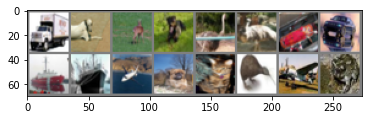

torch.Size([16, 3, 32, 32])


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.savefig('plot/result_sanity_'+str(batchSize)+'.png', dpi=500)
    plt.show()
    

# get some random training images
dataiter = iter(trainloader_color)
images_color, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images_color))

# show dataiter shape
print(images_color.shape)

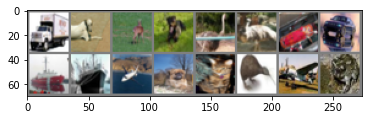

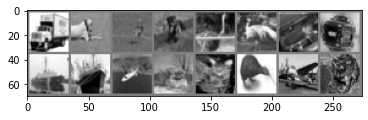

images_gray shape:  torch.Size([16, 1, 32, 32])


In [4]:
# function to convert a rgb_img to gray_img
def rgb2gray(img):

    rgb_img = img.transpose(1,2,0)
    gray_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)
    return gray_img

# function to convert a batch of rgb images to gray images
def rgb2gray_batch(images):
    rgb_images = np.array(images)    
#     print("rgb_images: ", rgb_images.shape)
    
    gray_images = []
    for i in range(rgb_images.shape[0]):
        img = rgb_images[i]
#         print("img: ", img.shape)
        gray_img = rgb2gray(img)
        gray_images.append(gray_img)
    
    gray_images = np.array(gray_images)
    gray_images = torch.from_numpy(gray_images)
    return gray_images
        
images_gray = rgb2gray_batch(images_color)

# show images
images_gray = images_gray.reshape(batchSize,1,32,32)

imshow(torchvision.utils.make_grid(images_color))
imshow(torchvision.utils.make_grid(images_gray))
print("images_gray shape: ", images_gray.shape)

### Define the MLP network

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class MLP_net(nn.Module):
    def __init__(self):
        # Input layer is 1024, since CIFAR-10 gray_image is 32x32
        # Output layer is 3072, since CIFAR-10 gray_image is 32x32x3
        super(MLP_net, self).__init__()
        
        self.layer1 = nn.Linear(1024,512)
        self.bn1 = nn.BatchNorm1d(512)
        self.layer2 = nn.Linear(512,256)
        self.bn2 = nn.BatchNorm1d(256)
        self.layer3 = nn.Linear(256,512)
        self.bn3 = nn.BatchNorm1d(512)
        self.layer4 = nn.Linear(512,1024)
        self.bn4 = nn.BatchNorm1d(1024)
        self.layer5 = nn.Linear(1024,3072)
        
    def forward(self, x):
        # convert tensor (4, 1, 32, 32) --> (4, 1*32*32)
        x = x.view(x.size(0), -1)
        
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.layer3(x)
        x = self.bn3(x)
        x = self.layer4(x)
        x = self.bn4(x)
        x = self.layer5(x)
        
        return x
        
mlp_net = MLP_net().to(device)

print("is cude: ", next(mlp_net.parameters()).is_cuda)

model_path = "./saved_model/AutoEncoder_mlp_"+str(batchSize)+ "_entireData.pt"
if os.path.exists(model_path):
    print("Continue training from the saved model")
    mlp_net.load_state_dict(torch.load(model_path))

is cude:  True
Continue training from the saved model


### Define the loss function and optimizer

In [6]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(mlp_net.parameters(), lr=0.001, momentum=0.9)

### Tensorboard to save all training output logs

In [7]:
from torch.utils.tensorboard import SummaryWriter

# Writer will output to ./runs/ directory by default
writer = SummaryWriter("./runs/AutoEncoder_mlp_"+str(batchSize)+"/")

### Train the network

In [8]:
for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0
    num_training = 0
    for i, data_color in enumerate(trainloader_color, 0):
        # get the inputs; data is a list of [inputs, labels]
        images_color, labels_color = data_color
        images_gray = rgb2gray_batch(images_color)

        # put data in gpu/cpu
        images_color = images_color.to(device)
        images_gray = images_gray.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # input: images_gray
        images_gray = images_gray.view(images_gray.shape[0],-1)
        outputs = mlp_net(images_gray)
        # images_color: [batchSize,3,32,32] -> [batchSize,3072]
        images_color = images_color.reshape(images_color.shape[0], -1) 
        loss = criterion(outputs, images_color)
        loss.backward()
        optimizer.step()

        # print output statistics
        running_loss += loss.item()

        j = 500              # print every 200 mini-batches
        if i % j == (j-1):     # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / j))
            
            writer.add_scalar('Loss/train', running_loss/j, len(trainset_color)*epoch + i)
            running_loss = 0.0
            
writer.flush()
writer.close()
print('Finished Training')

[1,   500] loss: 0.258
[1,  1000] loss: 0.255
[1,  1500] loss: 0.252
[1,  2000] loss: 0.249
[1,  2500] loss: 0.236
[1,  3000] loss: 0.222
[2,   500] loss: 0.201
[2,  1000] loss: 0.190
[2,  1500] loss: 0.181
[2,  2000] loss: 0.178
[2,  2500] loss: 0.171
[2,  3000] loss: 0.169
[3,   500] loss: 0.165
[3,  1000] loss: 0.161
[3,  1500] loss: 0.157
[3,  2000] loss: 0.153
[3,  2500] loss: 0.152
[3,  3000] loss: 0.152
[4,   500] loss: 0.149
[4,  1000] loss: 0.148
[4,  1500] loss: 0.146
[4,  2000] loss: 0.144
[4,  2500] loss: 0.144
[4,  3000] loss: 0.143
[5,   500] loss: 0.141
[5,  1000] loss: 0.139
[5,  1500] loss: 0.137
[5,  2000] loss: 0.138
[5,  2500] loss: 0.136
[5,  3000] loss: 0.134
[6,   500] loss: 0.134
[6,  1000] loss: 0.132
[6,  1500] loss: 0.133
[6,  2000] loss: 0.131
[6,  2500] loss: 0.131
[6,  3000] loss: 0.132
[7,   500] loss: 0.130
[7,  1000] loss: 0.131
[7,  1500] loss: 0.128
[7,  2000] loss: 0.128
[7,  2500] loss: 0.128
[7,  3000] loss: 0.128
[8,   500] loss: 0.126
[8,  1000] 

### Inference on original data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])
third_tensor:  torch.Size([16, 3, 32, 32])
outputs:  torch.Size([16, 3072])
outputs:  torch.Size([16, 3, 32, 32])


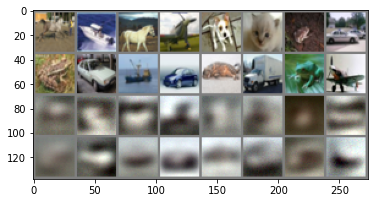

In [9]:
# get some random training images
images_color, images_label = next(iter(trainloader_color))
images_color_show = images_color.reshape(batchSize,3,32,32)
print(images_color.shape)
images_gray = rgb2gray_batch(images_color)
print("images_gray: ", images_gray.shape)
images_gray = images_gray.reshape(batchSize,1,32,32)
third_tensor = torch.cat((images_gray, images_gray, images_gray), 1)
print("third_tensor: ", third_tensor.shape)

images_gray = images_gray.to(device)
outputs = mlp_net(images_gray)
print("outputs: ", outputs.shape)

outputs = outputs.reshape(batchSize,3,32,32)
print("outputs: ", outputs.shape)

outputs = outputs.to("cpu")
result_display = torch.cat((images_color_show, outputs), 0)
    
imshow(torchvision.utils.make_grid(result_display.detach(), nrow=8))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([16, 3, 32, 32])
images_gray:  torch.Size([16, 32, 32])
third_tensor:  torch.Size([16, 3, 32, 32])
outputs:  torch.Size([16, 3072])
outputs:  torch.Size([16, 3, 32, 32])


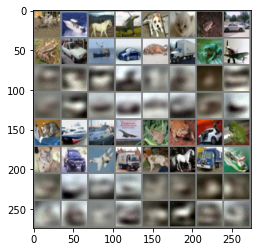

In [10]:
for i in range(1):
    # get some random training images
    images_color, images_label = next(iter(testloader_color))
    images_color_show = images_color.reshape(batchSize,3,32,32)
    print(images_color.shape)
    images_gray = rgb2gray_batch(images_color)
    print("images_gray: ", images_gray.shape)
    images_gray = images_gray.reshape(batchSize,1,32,32)
    third_tensor = torch.cat((images_gray, images_gray, images_gray), 1)
    print("third_tensor: ", third_tensor.shape)

    images_gray = images_gray.to(device)
    outputs = mlp_net(images_gray)
    print("outputs: ", outputs.shape)

    outputs = outputs.reshape(batchSize,3,32,32)
    print("outputs: ", outputs.shape)

    outputs = outputs.to("cpu")
    new_result_display = torch.cat((images_color_show, outputs), 0)
    result_display = torch.cat((result_display, new_result_display), 0)
    
imshow(torchvision.utils.make_grid(result_display.detach(), nrow=8))

### Save the model

In [11]:
if not os.path.exists('./saved_model'):
    os.makedirs('./saved_model')

    
torch.save(mlp_net.state_dict(), model_path)